# ML - BANK MARKETING PREDICTION

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams["figure.figsize"]= (12, 7)

## Loading the dataset

In [2]:
df = pd.read_csv("D:/work/Machine learning/codes/boardinfinity/ml project_1/bank-marketing.csv")
df.head()

,age,job,salary,marital,education,targeted,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,58,management,100000,married,tertiary,yes,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,60000,single,secondary,yes,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,120000,married,secondary,yes,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,20000,married,unknown,no,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,0,single,unknown,no,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Data Exploration

In [3]:
df.describe()

,age,salary,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,57006.171065,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,32085.718415,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,0.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,20000.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,60000.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,70000.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,120000.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [4]:
df.shape

(45211, 19)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   salary     45211 non-null  int64 
 3   marital    45211 non-null  object
 4   education  45211 non-null  object
 5   targeted   45211 non-null  object
 6   default    45211 non-null  object
 7   balance    45211 non-null  int64 
 8   housing    45211 non-null  object
 9   loan       45211 non-null  object
 10  contact    45211 non-null  object
 11  day        45211 non-null  int64 
 12  month      45211 non-null  object
 13  duration   45211 non-null  int64 
 14  campaign   45211 non-null  int64 
 15  pdays      45211 non-null  int64 
 16  previous   45211 non-null  int64 
 17  poutcome   45211 non-null  object
 18  response   45211 non-null  object
dtypes: int64(8), object(11)
memory usage: 6.6+ MB


In [6]:
df.isnull().sum()

age          0
job          0
salary       0
marital      0
education    0
targeted     0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
response     0
dtype: int64

__Fortunatly there are no missing values for any feature.__

In [7]:
df.head()

,age,job,salary,marital,education,targeted,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,58,management,100000,married,tertiary,yes,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,60000,single,secondary,yes,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,120000,married,secondary,yes,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,20000,married,unknown,no,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,0,single,unknown,no,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


__There are many 'unknown' values under Categorical variables. We have to treat them!!!__

In [8]:
# Target variable distribution
count = df.groupby('response').size()
percent = count/len(df)*100
print(percent)

response
no     88.30152
yes    11.69848
dtype: float64


__From the distribution of Target variable "response" it is found that data is imbalanced because approx 88% is 'no' and 12% is 'yes'.__

# Analysis of Indepedent Numerical Variables

## Note:

I have did analysis of each individual variable and checking if there is any outlier values present.
Outliers can be defined as values out of range but here I choose a range based on Maximum and
Minimum value for each variable selected by observing Boxplot of corresponding variable.
After identifing the Outliers, the values will be imputed by "mean" of respective variable by implementation of following "impute_outliers" function.

In [9]:
# Impute outliers function
def impute_outliers(df, column , minimum, maximum):
    col_values = df[column].values
    df[column] = np.where(np.logical_or(col_values<minimum, col_values>maximum), col_values.mean(), col_values)
    return df

In [10]:
#lets see statistic of Numerical variables before Outlier treatment
df.describe()

,age,salary,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,57006.171065,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,32085.718415,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,0.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,20000.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,60000.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,70000.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,120000.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


__From the above result one can see that some variables ('salary', 'duration', 'campaign', 'pdays', 'previous') has outliers. That can also visualize through graph further.__

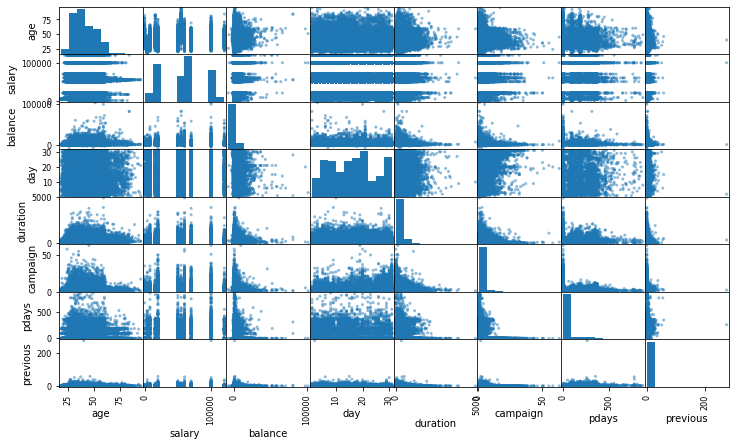

In [11]:
# scatter plot matrix
pd.plotting.scatter_matrix(df)
plt.show()

__Scatter plot matrix showing that there is no strong relationship between these indepedent variables (no multicollinearity among these).__

__Lets analyze all Independent Numerical variables against Target variable 'response' by plotting Boxplot. We can easily find outliers through Boxplot.__

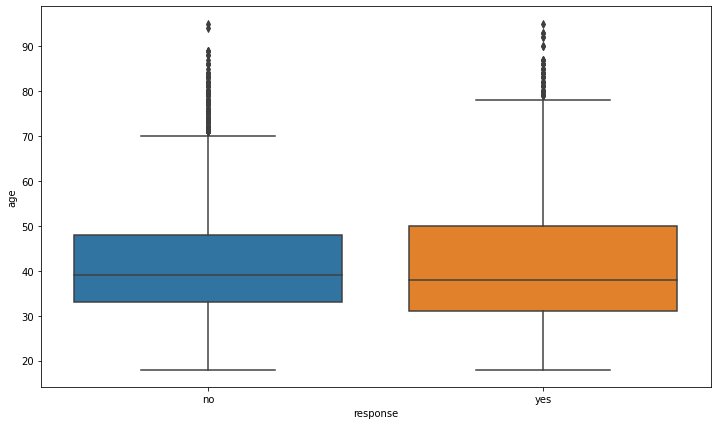

In [12]:
# age

sns.boxplot(x='response', y='age', data=df);

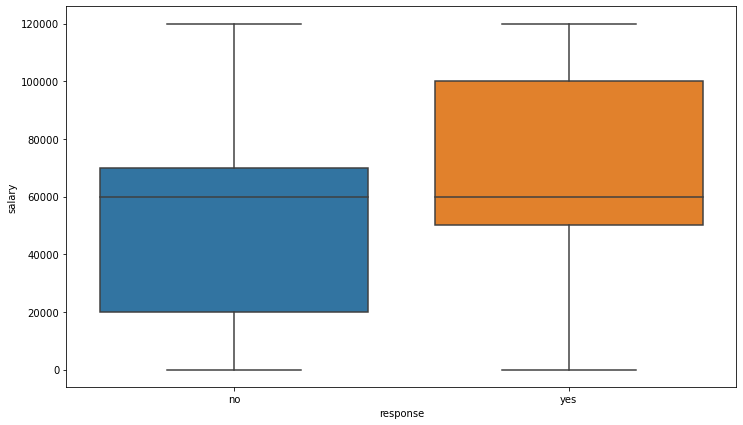

In [13]:
#salary

sns.boxplot(x='response', y='salary', data=df);

In [14]:
# Fixing balance column
dataset_new = df
min_val = dataset_new["balance"].min()
max_val = 20000
dataset_new = impute_outliers(df=dataset_new, column='balance' , minimum=min_val, maximum=max_val)

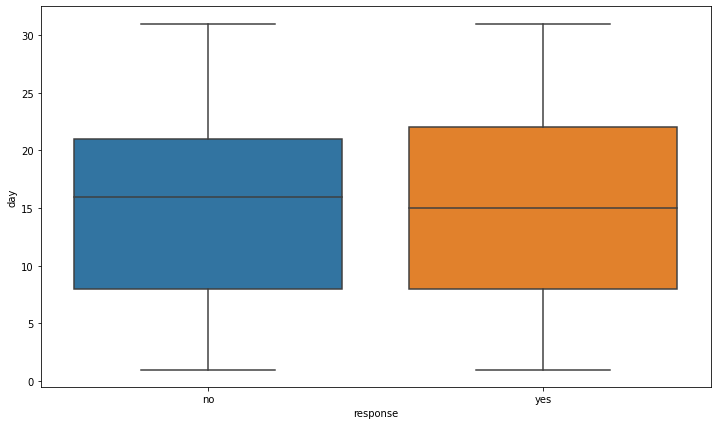

In [15]:
#day

sns.boxplot(x='response', y='day', data=df);

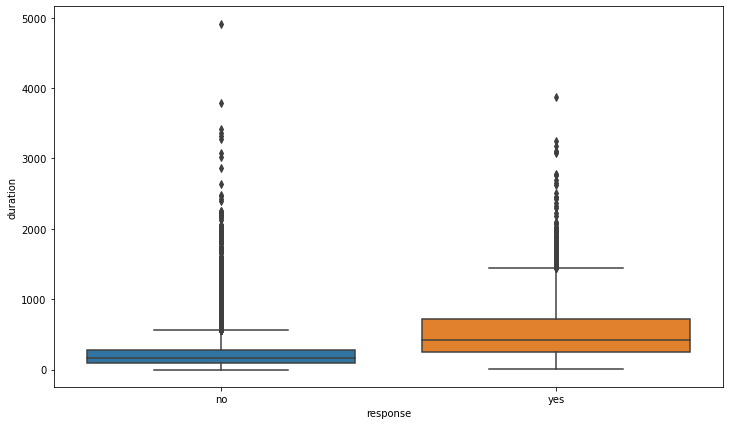

In [16]:
#duration

sns.boxplot(x='response', y='duration', data=df);

In [17]:
# Fixing duration column
min_val = dataset_new["duration"].min()
max_val = 2000
dataset_new = impute_outliers(df=dataset_new, column='duration' , minimum=min_val, maximum=max_val)

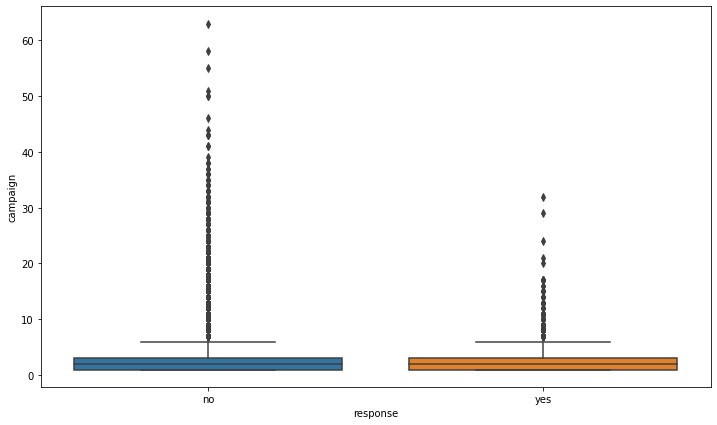

In [18]:
#campaign

sns.boxplot(x='response', y='campaign', data=df);

In [19]:
# Fixing campaign column
min_val = dataset_new["campaign"].min()
max_val = 20
dataset_new = impute_outliers(df=dataset_new, column='campaign' , minimum=min_val, maximum=max_val)

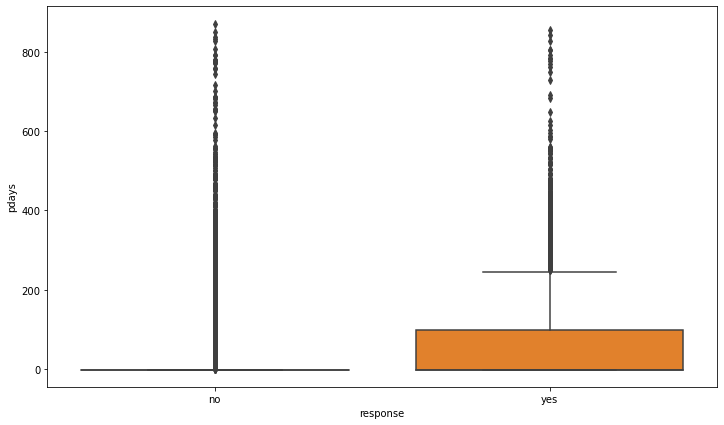

In [20]:
#pdays

sns.boxplot(x='response', y='pdays', data=df);

In [21]:
# Fixing pdays column
min_val = dataset_new["pdays"].min()
max_val = 250
dataset_new = impute_outliers(df=dataset_new, column='pdays' , minimum=min_val, maximum=max_val)

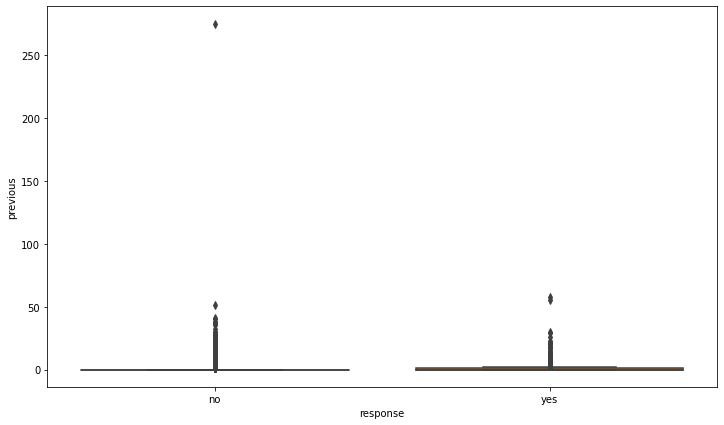

In [22]:
#previous

sns.boxplot(x='response', y='previous', data=df);

In [23]:
# Fixing 'previous' column
min_val = dataset_new["previous"].min()
max_val = 15
dataset_new = impute_outliers(df=dataset_new, column='previous' , minimum=min_val, maximum=max_val)

In [24]:
#lets see statistic of Numerical variables after Outlier treatment
dataset_new.describe()

,age,salary,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,57006.171065,1239.089967,15.806419,255.154379,2.630474,17.370434,0.520972
std,10.618762,32085.718415,2213.867032,8.322476,242.792228,2.456852,47.938636,1.512395
min,18.000000,0.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,20000.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,60000.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,70000.000000,1397.000000,21.000000,318.000000,3.000000,-1.000000,0.000000
max,95.000000,120000.000000,19985.000000,31.000000,1994.000000,20.000000,250.000000,15.000000


__Now the data seems quite stable comparision to original.__

# Analysis of Indepedent Categorical Variables

In [25]:
# Impute unknowns function
def impute_unknowns(df, column):
    col_values = df[column].values
    df[column] = np.where(col_values=='unknown', dataset[column].mode(), col_values)
    return df

job
admin.           11.437482
blue-collar      21.525735
entrepreneur      3.289023
housemaid         2.742695
management       20.919688
retired           5.007631
self-employed     3.492513
services          9.188029
student           2.074716
technician       16.803433
unemployed        2.882042
unknown           0.637013
dtype: float64


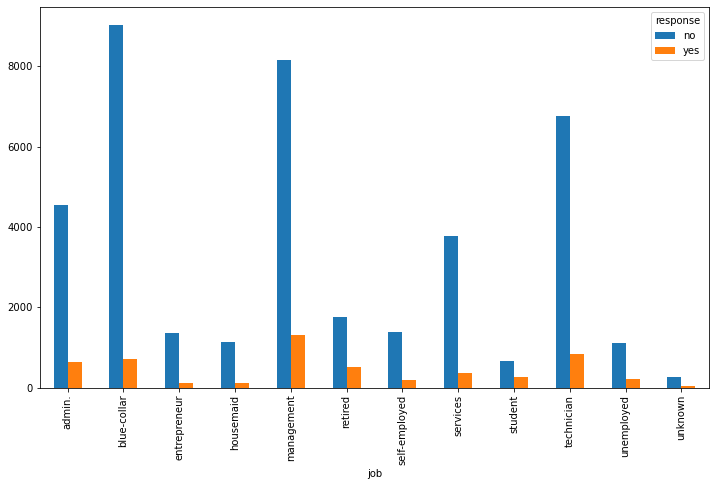

In [26]:
# job
temp1 = pd.crosstab(df['job'], df['response'])
temp1.plot(kind='bar')
print(df.groupby(['job']).size()/len(df)*100)

marital
divorced    11.517109
married     60.193316
single      28.289576
dtype: float64


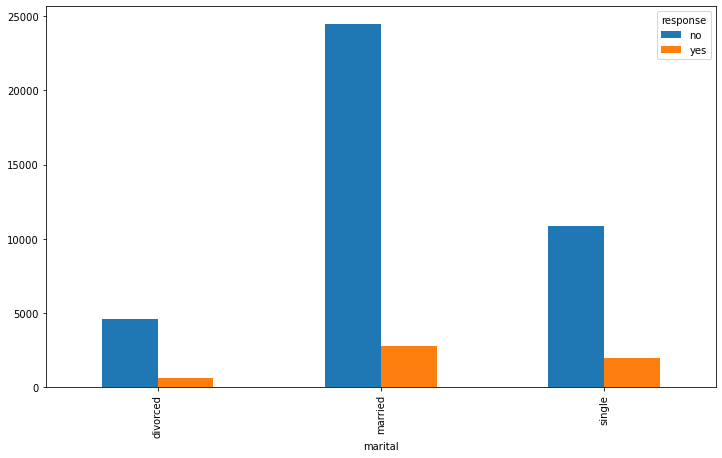

In [27]:
# marital
temp2 = pd.crosstab(df['marital'], df['response'])
temp2.plot(kind='bar')
print(df.groupby(['marital']).size()/len(df)*100)

education
primary      15.153392
secondary    51.319369
tertiary     29.419831
unknown       4.107407
dtype: float64


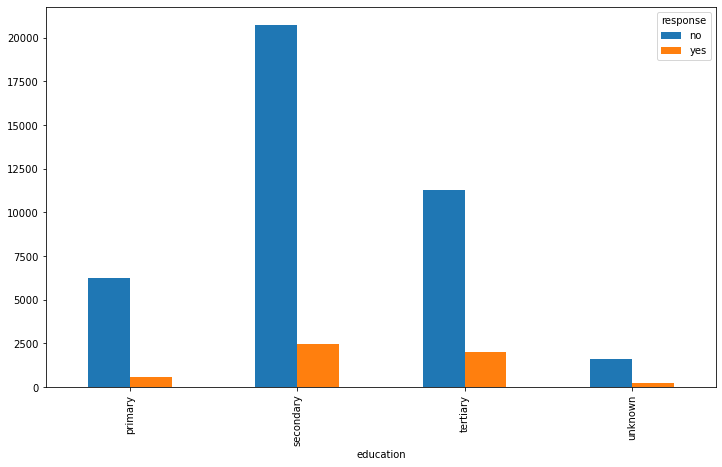

In [28]:
# education
temp3 = pd.crosstab(df['education'], df['response'])
temp3.plot(kind='bar')
print(df.groupby(['education']).size()/len(df)*100)

default
no     98.197341
yes     1.802659
dtype: float64


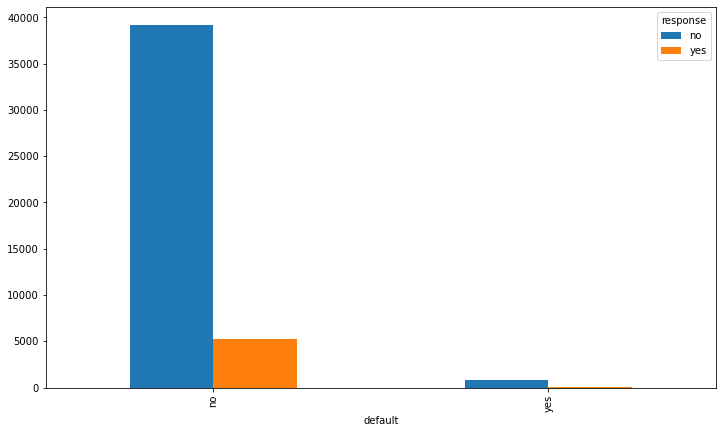

In [29]:
# default
temp4 = pd.crosstab(df['default'], df['response'])
temp4.plot(kind='bar')
print(df.groupby(['default']).size()/len(df)*100)

housing
no     44.416182
yes    55.583818
dtype: float64


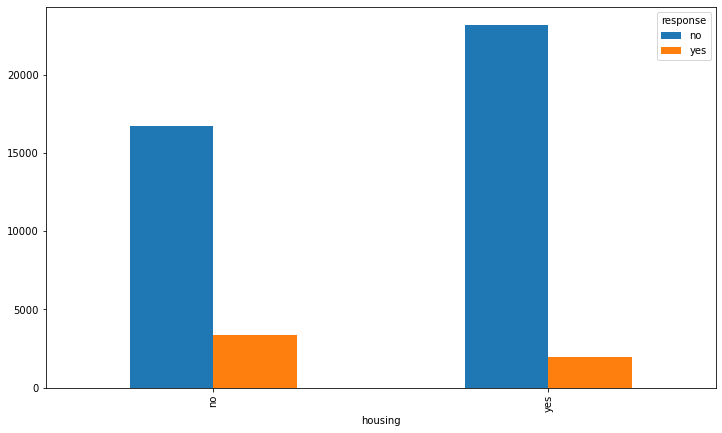

In [30]:
# housing
temp5 = pd.crosstab(df['housing'], df['response'])
temp5.plot(kind='bar')
print(df.groupby(['housing']).size()/len(df)*100)

contact
cellular     64.774059
telephone     6.427639
unknown      28.798301
dtype: float64


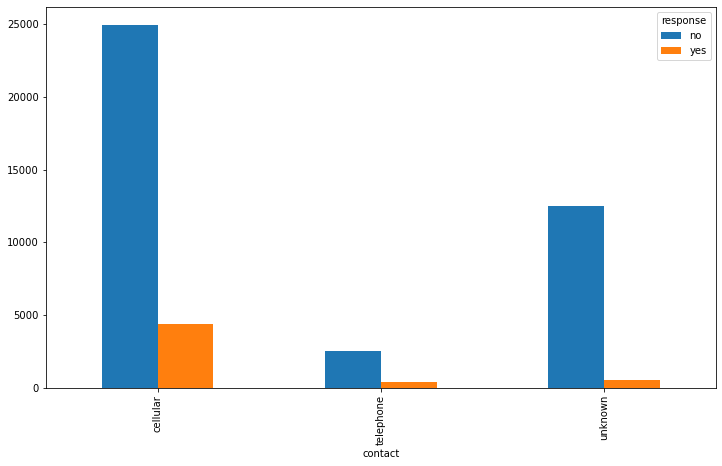

In [31]:
# "contact"
temp6 = pd.crosstab(df['contact'], df['response'])
temp6.plot(kind='bar')
print(df.groupby(['contact']).size()/len(df)*100)

month
apr     6.485147
aug    13.817434
dec     0.473336
feb     5.859194
jan     3.103227
jul    15.250713
jun    11.813497
mar     1.055053
may    30.448342
nov     8.781049
oct     1.632346
sep     1.280662
dtype: float64


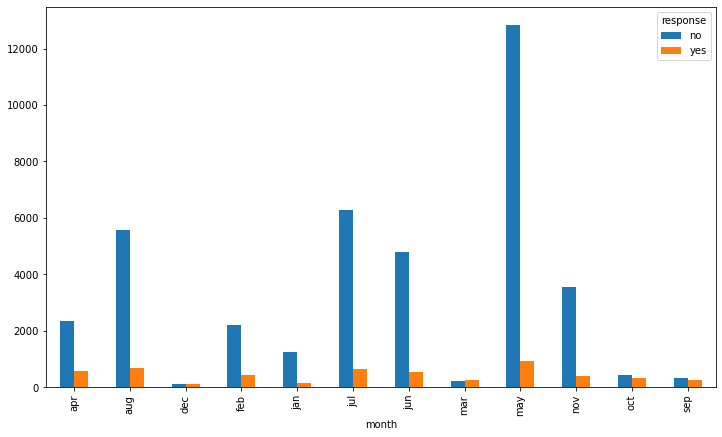

In [32]:
# "month"
temp7 = pd.crosstab(df['month'], df['response'])
temp7.plot(kind='bar')
print(df.groupby(['month']).size()/len(df)*100)

poutcome
failure    10.840282
other       4.069806
success     3.342107
unknown    81.747805
dtype: float64


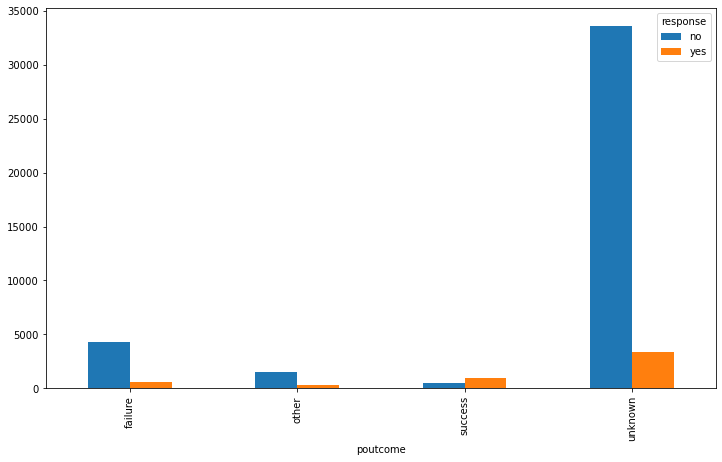

In [33]:
# "poutcome"
temp8 = pd.crosstab(df['poutcome'], df['response'])
temp8.plot(kind='bar')
print(df.groupby(['poutcome']).size()/len(df)*100)

loan
no     83.977351
yes    16.022649
dtype: float64


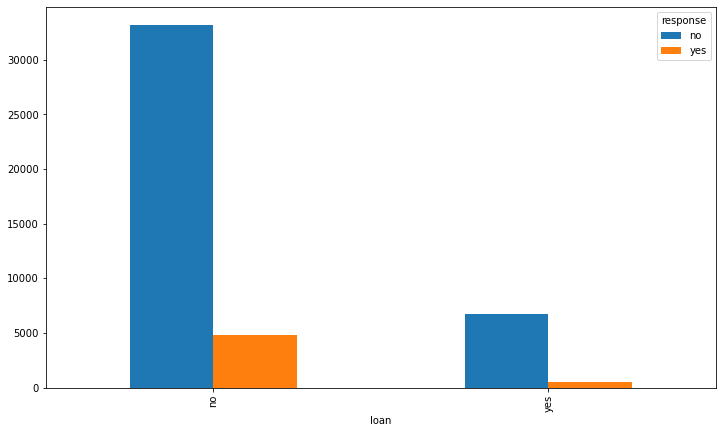

In [34]:
# "loan"
temp9 = pd.crosstab(df['loan'], df['response'])
temp9.plot(kind='bar')
print(df.groupby(['loan']).size()/len(df)*100)

# Updated Dataset after Exploratary Data Analysis:

In [35]:
dataset_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        45211 non-null  int64  
 1   job        45211 non-null  object 
 2   salary     45211 non-null  int64  
 3   marital    45211 non-null  object 
 4   education  45211 non-null  object 
 5   targeted   45211 non-null  object 
 6   default    45211 non-null  object 
 7   balance    45211 non-null  float64
 8   housing    45211 non-null  object 
 9   loan       45211 non-null  object 
 10  contact    45211 non-null  object 
 11  day        45211 non-null  int64  
 12  month      45211 non-null  object 
 13  duration   45211 non-null  float64
 14  campaign   45211 non-null  float64
 15  pdays      45211 non-null  float64
 16  previous   45211 non-null  float64
 17  poutcome   45211 non-null  object 
 18  response   45211 non-null  object 
dtypes: float64(5), int64(3), object(11)
memory usa

## Feature Engineering

In [36]:
#Seperating Target variable from other variables
y = dataset_new['response']
X = dataset_new[dataset_new.columns[0:12]]

In [37]:
#converting Independent Categorical into Numeriacal by creating Dummy variables
X = pd.get_dummies(X, drop_first=True)
(X.head())

,age,salary,balance,day,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,marital_single,education_secondary,education_tertiary,education_unknown,targeted_yes,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown
0,58,100000,2143.0,5,0,0,0,1,0,0,...,0,0,1,0,1,0,1,0,0,1
1,44,60000,29.0,5,0,0,0,0,0,0,...,1,1,0,0,1,0,1,0,0,1
2,33,120000,2.0,5,0,1,0,0,0,0,...,0,1,0,0,1,0,1,1,0,1
3,47,20000,1506.0,5,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
4,33,0,1.0,5,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1


__After creating Dummy Variables we have now 26 Variables.__

## Feature Selection with PCA

In [38]:
# Split-out validation dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [39]:
#Scaling the values
X_t = scale(X_train)

#initially lets create 26 components which is actual number of Variables we have
pca = PCA(n_components=26)

pca.fit(X_t)

#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

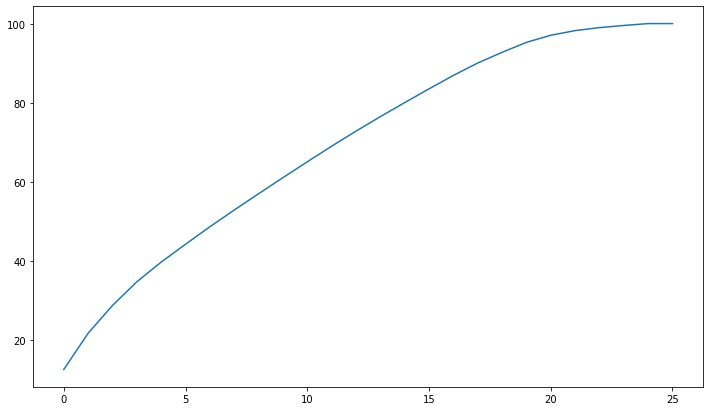

In [40]:
#lets see Cumulative Variance plot
plt.plot(var1);

__From Cumulative Variance plot we can find that first 25 components are explaining nearly 100% variability of actual data. So we will proceed with only 25 components for further modelling__

In [41]:
#Looking at above plot I'm taking 25 variables
pca = PCA(n_components=25)
pca.fit(X_t)
X_train_PC=pca.fit_transform(X_t)

# Model Training

In [42]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

In [43]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('RFA', RandomForestRegressor()))

In [44]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train_PC, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.881746 (0.005083)
RFA: nan (nan)


# Model Selection

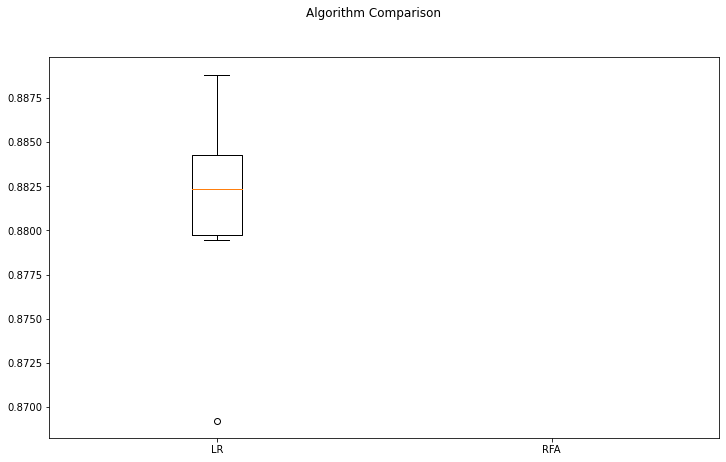

In [45]:
# Comparing Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results);
ax.set_xticklabels(names);

# Making Prediction

In [46]:
#Scaling the X_test data
X_v = scale(X_test)

pca.fit(X_v)
X_test_PC=pca.fit_transform(X_v)

In [47]:
# Make predictions on test dataset by choosing best Algorithm
lr = LogisticRegression()
lr.fit(X_train_PC, y_train)
predictions = lr.predict(X_test_PC)
print("Accuracy : ", accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy :  0.8877584872276899
[[8027    0]
 [1015    1]]
              precision    recall  f1-score   support

          no       0.89      1.00      0.94      8027
         yes       1.00      0.00      0.00      1016

    accuracy                           0.89      9043
   macro avg       0.94      0.50      0.47      9043
weighted avg       0.90      0.89      0.84      9043



## Main challenge in this model was Exploratary Data Analysis on Unbalaced Data.
## We can further increase our Model performance by proper data cleaning and model tuning.